In [1]:
library(tidyverse)
library(WGCNA)
library(cowplot)
library(matrixStats)

# Custom package
library(rutils)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: dynamicTreeCut
Loading required package: fastcluster

Attaching package: ‘fastcluster’

The following object is masked from ‘package:stats’:

    hclust



Attaching package: ‘WGCNA’

The following object is masked from ‘package:stats’:

    cor


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: ‘matrixStats’

The following object is masked 

In [2]:
options(stringsAsFactors = FALSE)
enableWGCNAThreads()

Allowing parallel execution with up to 15 working processes.


In [3]:
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)

In [4]:
dset_idx <- 3

# Load data

In [5]:
clinical_df <- load_survival_df(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv"), event_code) %>%
    dplyr::select(sample_name, vital_status, survival_time, figo_stage) %>%
    dplyr::filter(rowSums(is.na(.)) == 0)

tumor_coldata_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/coldata.tsv")) %>%
    dplyr::filter(condition == "tumor")

matrisome_counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/matrisome_counts.tsv")) %>%
    dplyr::select(one_of(c("geneID", tumor_coldata_df$sample_name)))
# We want to drop genes that are unexpressed from the analysis
unexpressed_genes <- matrisome_counts_df %>% 
    dplyr::filter(rowSums(.[, -1]) == 0) %>% 
    dplyr::pull(geneID)

matrisome_norm_counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv")) %>%
    dplyr::select(one_of(c("geneID", tumor_coldata_df$sample_name))) %>%
    dplyr::filter(!(geneID %in% unexpressed_genes)) %>%    # Drop unexpressed genes
    transpose_df(future_colnames_col = "geneID", previous_colnames_col = "sample_name") %>%
    dplyr::filter(sample_name %in% clinical_df$sample_name)    # Drop samples with missing vital/FIGO data

filtered_matrisome_df <- load_matrisome_df(matrisome_path) %>%
    dplyr::select(gene_symbol, division, category, gene_name, synonyms) %>%
    dplyr::filter(gene_symbol %in% colnames(matrisome_norm_counts_df))    # Only include genes in dataset

data_expr <- matrisome_norm_counts_df %>% column_to_rownames("sample_name")

Parsed with column specification:
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  data_source = col_character()
)
Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  geneID = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  Division = col_character(),
  Category = col_character(),
  `Gene Symbol` = col_character(),
  `

# Find soft thresholding power

In [6]:
sft <- pickSoftThreshold(data = data_expr, verbose = FALSE)

   Power SFT.R.sq   slope truncated.R.sq  mean.k. median.k. max.k.
1      1 0.000896  0.0855          0.974 120.0000  1.20e+02 188.00
2      2 0.481000 -1.3300          0.976  24.5000  2.29e+01  63.10
3      3 0.841000 -1.8800          0.983   6.9200  5.57e+00  30.10
4      4 0.915000 -1.9500          0.945   2.5100  1.63e+00  17.50
5      5 0.940000 -1.8200          0.964   1.1000  5.40e-01  11.30
6      6 0.974000 -1.6100          0.975   0.5590  2.00e-01   7.80
7      7 0.921000 -1.5500          0.910   0.3190  7.95e-02   5.62
8      8 0.913000 -1.4300          0.890   0.1990  3.33e-02   4.19
9      9 0.915000 -1.4000          0.891   0.1320  1.45e-02   3.39
10    10 0.957000 -1.3700          0.945   0.0925  6.63e-03   2.91
11    12 0.326000 -2.0600          0.254   0.0512  1.51e-03   2.29
12    14 0.348000 -2.9600          0.311   0.0318  3.49e-04   1.94
13    16 0.383000 -3.1900          0.297   0.0216  9.00e-05   1.73
14    18 0.416000 -3.2800          0.280   0.0157  2.23e-05   

In [7]:
sft_df <- sft$fitIndices %>%
    as_tibble() %>%
    rename_with(function(c) { gsub("_$", "", tolower(gsub("\\.", "_", c))) }) %>%
    dplyr::mutate(scale_free_topology = -sign(slope) * sft_r_sq)
head(sft_df)

power,sft_r_sq,slope,truncated_r_sq,mean_k,median_k,max_k,scale_free_topology
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0008959414,0.08547265,0.9738006,119.971872,119.8793471,188.401297,-0.0008959414
2,0.4814040666,-1.33449115,0.9759295,24.460481,22.9280521,63.086422,0.4814040666
3,0.8407432793,-1.88293805,0.9830065,6.924949,5.5695701,30.093757,0.8407432793
4,0.9148126221,-1.94971782,0.9454136,2.505773,1.6332414,17.517943,0.9148126221
5,0.9398746342,-1.82394364,0.9644628,1.098687,0.5400144,11.308594,0.9398746342
6,0.9739255136,-1.61417553,0.9752160,0.559268,0.1997237,7.795402,0.9739255136


## Visualize

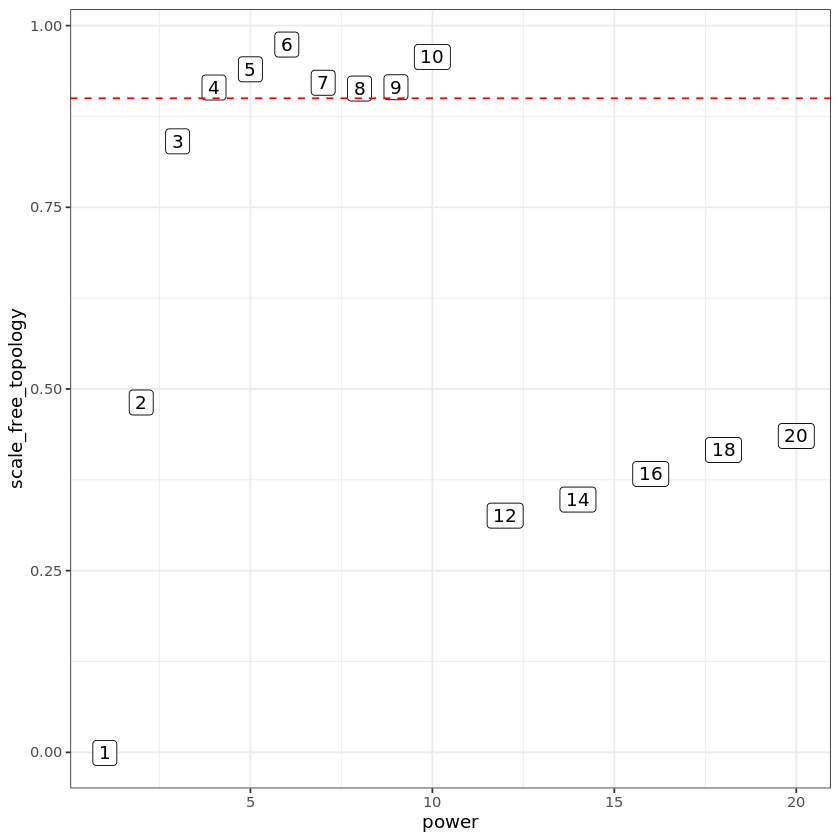

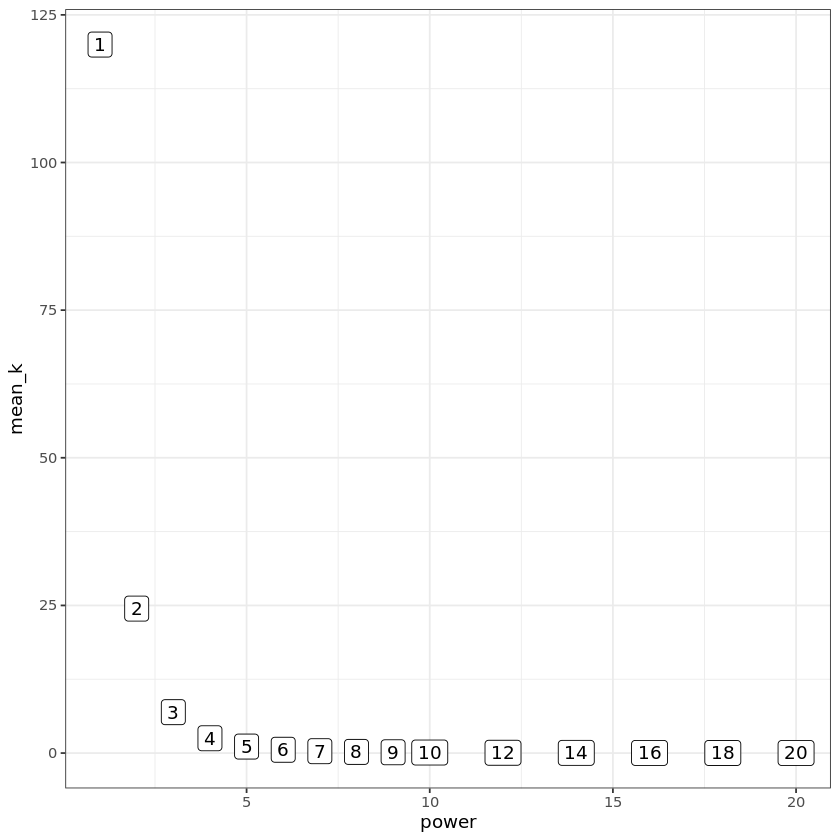

In [8]:
# sft_df
plt_1 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = scale_free_topology, label = power)) +
    geom_hline(yintercept = 0.9, color = "red", linetype = "dashed") +
    theme_bw()
plt_2 <- ggplot(sft_df) +
    geom_label(aes(x = power, y = mean_k, label = power)) +
    theme_bw()
# plot_grid(plt_1, plt_2, labels = c("A", "B"), rows = 1, align="h")
plt_1
plt_2

## Pick soft thresholding power

In [9]:
# Pick first power which yields close to 0.9 scale free topology
thresh <- 0.9
tol <- 1e-2

soft_power <- sft_df %>%
    dplyr::filter(scale_free_topology > 0.9 | abs(scale_free_topology - thresh) < tol) %>%
    top_n(n = 1, wt = desc(power)) %>%
    dplyr::pull(power)


In [10]:
soft_power

[1] 4

# Adjacency

In [11]:
adj <- adjacency(data_expr, power = soft_power, corOptions = list(method = "pearson"))

# Topological Overlap Matrix (TOM)

In [12]:
tom <- TOMsimilarity(adj)
diss_tom <- 1 - tom

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


# Cluster on TOM

In [13]:
gene_tree <- hclust(as.dist(diss_tom), method = "average")

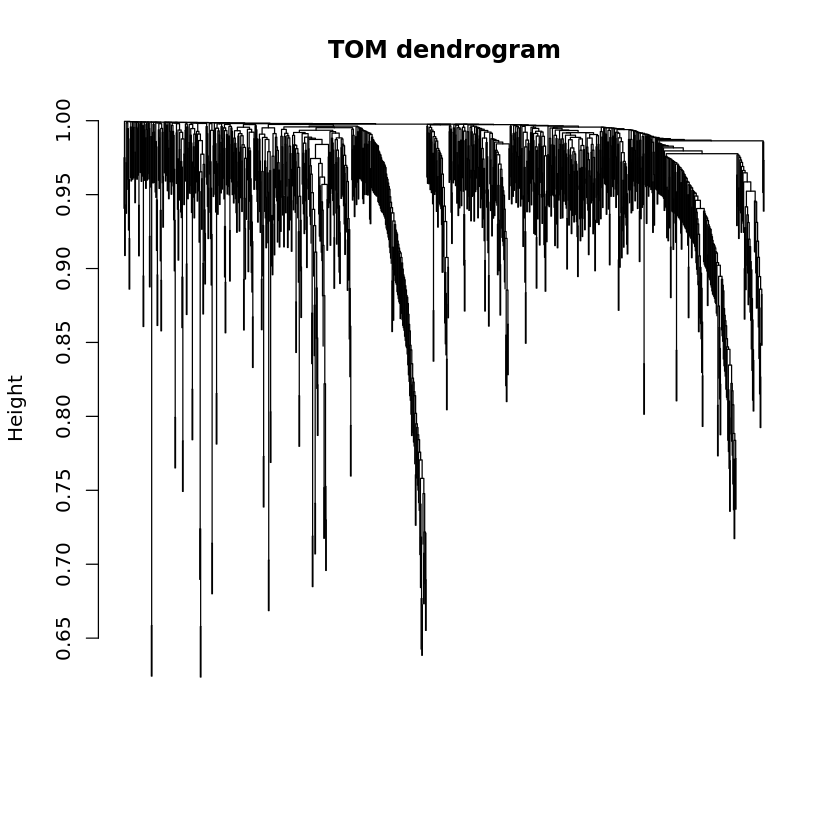

In [14]:
plot(gene_tree, labels = FALSE, xlab="", sub="", main = "TOM dendrogram")

In [15]:
# Set min. module size to 1/2 * min. matrisome category size
min_module_size <- filtered_matrisome_df %>%
    dplyr::group_by(category) %>%
    dplyr::summarize(n = n()) %>%
    top_n(n = 1, wt = desc(n)) %>%
    dplyr::pull(n) %>%
    (function(x) { round(x / 2) })

min_module_size

`summarise()` ungrouping output (override with `.groups` argument)


[1] 18

In [16]:
dynamic_mods <- cutreeDynamic(
    dendro = gene_tree, 
    distM = diss_tom, 
    deepSplit = TRUE, 
    pamRespectsDendro = FALSE, 
    minClusterSize = min_module_size
)
table(dynamic_mods)

 ..cutHeight not given, setting it to 0.998  ===>  99% of the (truncated) height range in dendro.
 ..done.


dynamic_mods
  0   1   2   3   4   5   6   7   8   9  10 
 56 232 135 132 110  76  73  59  54  46  34 

In [17]:
# Stacked bar chart?
module_counts <- dynamic_mods %>%
    as_tibble() %>%
    dplyr::rename(cluster = value) %>%
    dplyr::bind_cols(transpose_df(matrisome_norm_counts_df, future_colnames_col = "sample_name", previous_colnames_col = "geneID")) %>%
    dplyr::inner_join(filtered_matrisome_df, by = c("geneID" = "gene_symbol")) %>%
    dplyr::select(cluster, geneID, category) %>%
    dplyr::group_by(cluster, category) %>%
    summarize(n = n())

`summarise()` regrouping output by 'cluster' (override with `.groups` argument)


dynamic_colors
    black      blue     brown     green      grey   magenta      pink    purple 
       59       135       132        76        56        46        54        34 
      red turquoise    yellow 
       73       232       110 

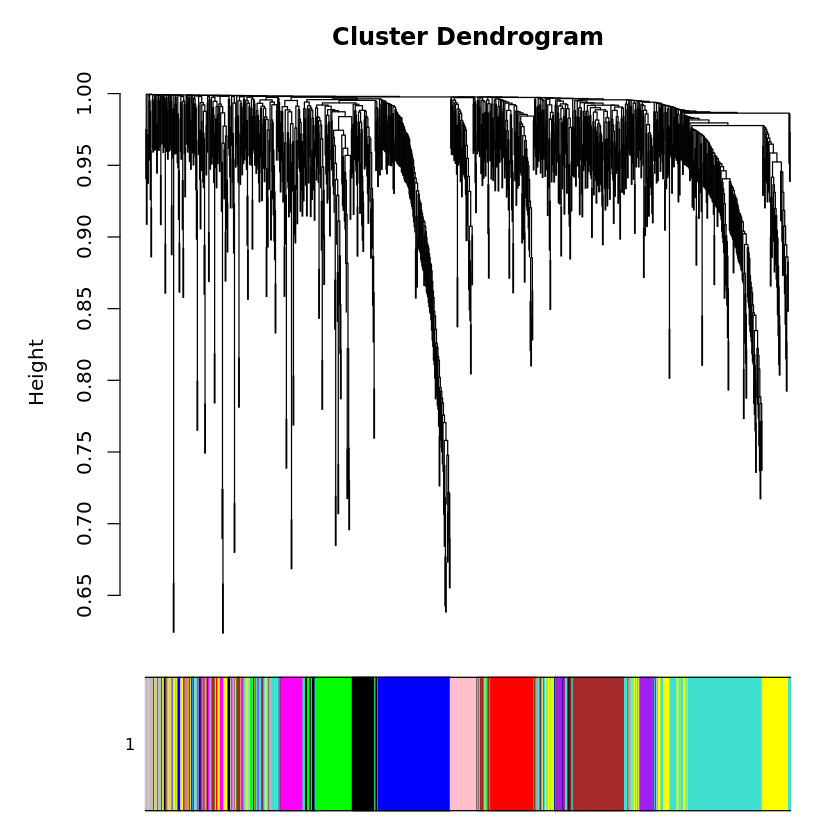

In [18]:
dynamic_colors <- labels2colors(dynamic_mods)
table(dynamic_colors)
plotDendroAndColors(gene_tree, dynamic_colors, dendroLabels = FALSE)

# Merge similar modules

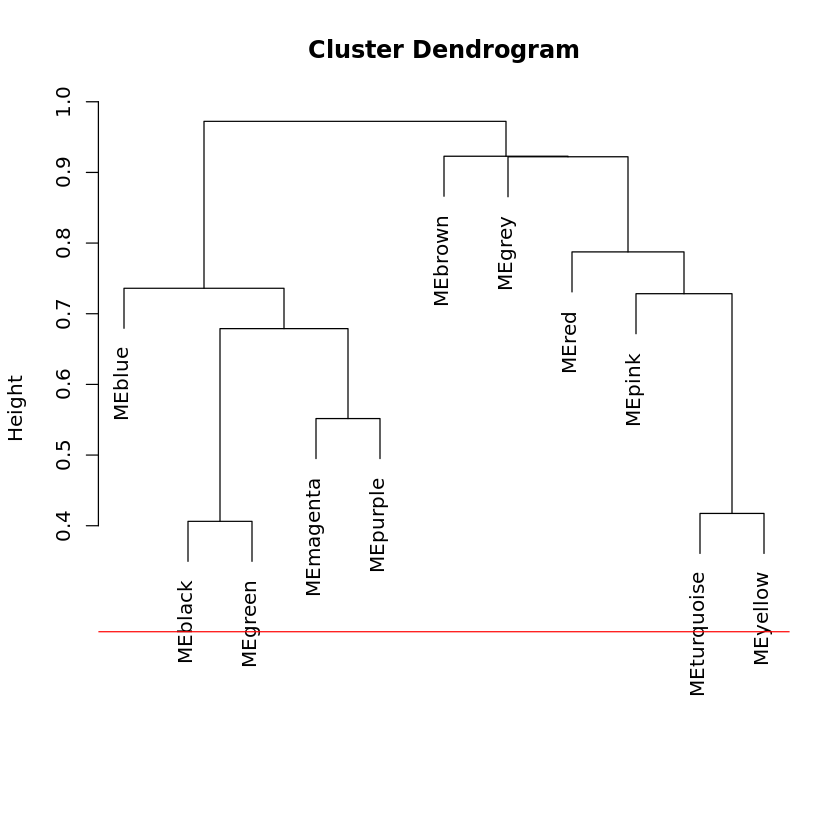

In [19]:
me_list <- moduleEigengenes(data_expr, colors = dynamic_colors)
mes <- me_list$eigengenes
me_diss <- 1 - WGCNA::cor(mes)
me_tree <- hclust(as.dist(me_diss), method = "average")
plot(me_tree, xlab = "", sub = "")

# Choose a correlation threshold
cor_thresh <- 0.75
me_diss_thresh <- 1 - cor_thresh
abline(h = me_diss_thresh, col = "red")

In [20]:
merged <- mergeCloseModules(data_expr, dynamic_colors, cutHeight = me_diss_thresh, verbose = 3)

 mergeCloseModules: Merging modules whose distance is less than 0.25
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.
   Calculating new MEs...
   multiSetMEs: Calculating module MEs.
     Working on set 1 ...
     moduleEigengenes: Calculating 11 module eigengenes in given set.


In [21]:
merged_colors <- merged$colors
merged_mes <- merged$newMEs

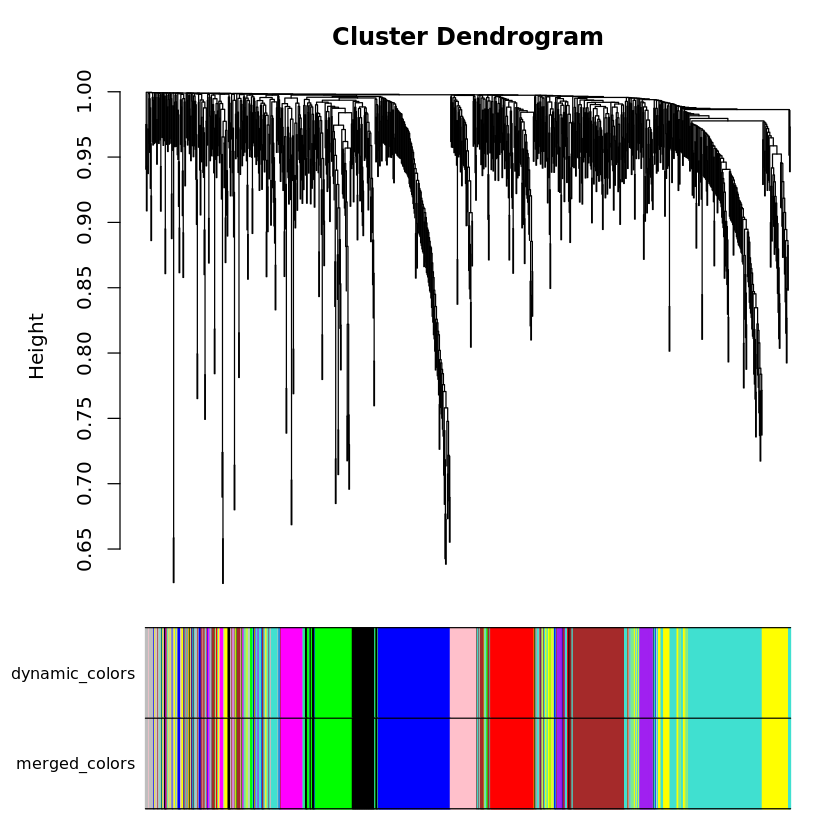

In [22]:
plotDendroAndColors(
    gene_tree, 
    cbind(dynamic_colors, merged_colors),
    dendroLabels = FALSE
)

In [23]:
module_colors <- merged_colors
color_order <- c("grey", standardColors())
module_labels <- match(module_colors, color_order) - 1
mes <- merged_mes

In [24]:
dir.create(paste0(dirs$data_dir, "/saved_network_objects/"), showWarnings = FALSE)
save(mes, module_labels, data_expr, module_colors, gene_tree, file = paste0(dirs$data_dir, "/saved_network_objects/", unified_dsets[dset_idx], "_cancer_network.RData"))